This scripts aggregate the mixed effect models

### Import


In [1]:
library(rstatix)
library(feather)
library(tidyverse)
library(rjson)
library(lme4)
library(reticulate)
library(ggeffects)
library(broom)
library(glue)
library(progress)
library(ggforce)
library(patchwork)
library(ggpubr)

knitr::opts_chunk$set(
  fig.show = "hold",
  fig.width = 7,
  fig.asp = 0.6
)



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks rstatix::filter(), stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




### Load data

In [2]:
data_merged <- readRDS('/mnt/datastore/Teris/CurrentBiology_2022/all_lme.rds') #load previous data

In [3]:
# data_merged <- data_merged %>%
#     mutate(lm_result_outbound = recode(classification, 'NoSlope'='Unclassified','None'='Unclassified'))

### Plot portion of cell encoding position or time 

### Figure D

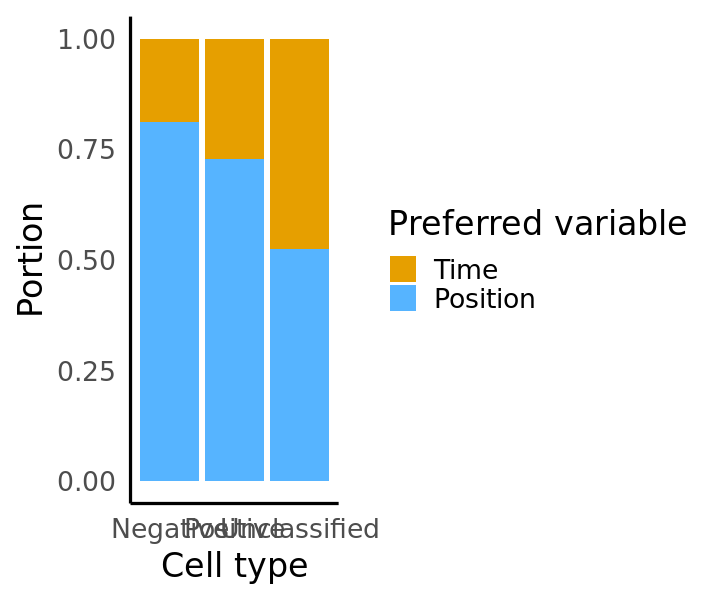

In [9]:
# use AIC for model comparison
options(repr.plot.width=6, repr.plot.height=5)

getPosAIC <- function(data) {
  data$AIC[[2]]
}

getTimeAIC <- function (data) {
  data$AIC[[1]]
}

data2plot <- data_merged %>%
  filter(models.trialN>10) %>% #only include data with enough trials
  filter(models.trial_length_type != "Middle") %>%
  mutate(pos_aic = map_dbl(models.anova_p_vs_t, getPosAIC)) %>%
  mutate(time_aic = map_dbl(models.anova_p_vs_t, getTimeAIC))  %>%
  mutate(aic_diff = abs(time_aic - pos_aic)/((pos_aic+time_aic)/2))

data2plot <- data2plot %>% 
  mutate(aic_compare=if_else(pos_aic<=time_aic,'Position','Time')) %>%
  mutate(aic_compare=factor(aic_compare,levels=c('Time','Position')))

p1 <- data2plot %>% 
    filter(models.trial_length_type=='All') %>%
    ggplot()+ 
      geom_bar(aes(x=lm_group_b,fill=aic_compare),position='fill') +
   labs(x='Cell type', y='Portion', fill='Preferred variable') +
    scale_fill_manual(values=c("#E69F00","#56B4FF")) + 
      theme_minimal(base_size=20) +
    theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),axis.line = element_line())

p1
ggsave('paper_figures/timeAnalysis_D.pdf',width=8,height=5)


# p1+p2 + plot_layout(widths = c(1, 2))

In [6]:
saveRDS(data2plot, '/mnt/datastore/Teris/CurrentBiology_2022/s5d_data.rds' )

### Figure E

Warning message:
“Removed 56 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 56 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 56 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 56 rows containing non-finite values (stat_signif).”


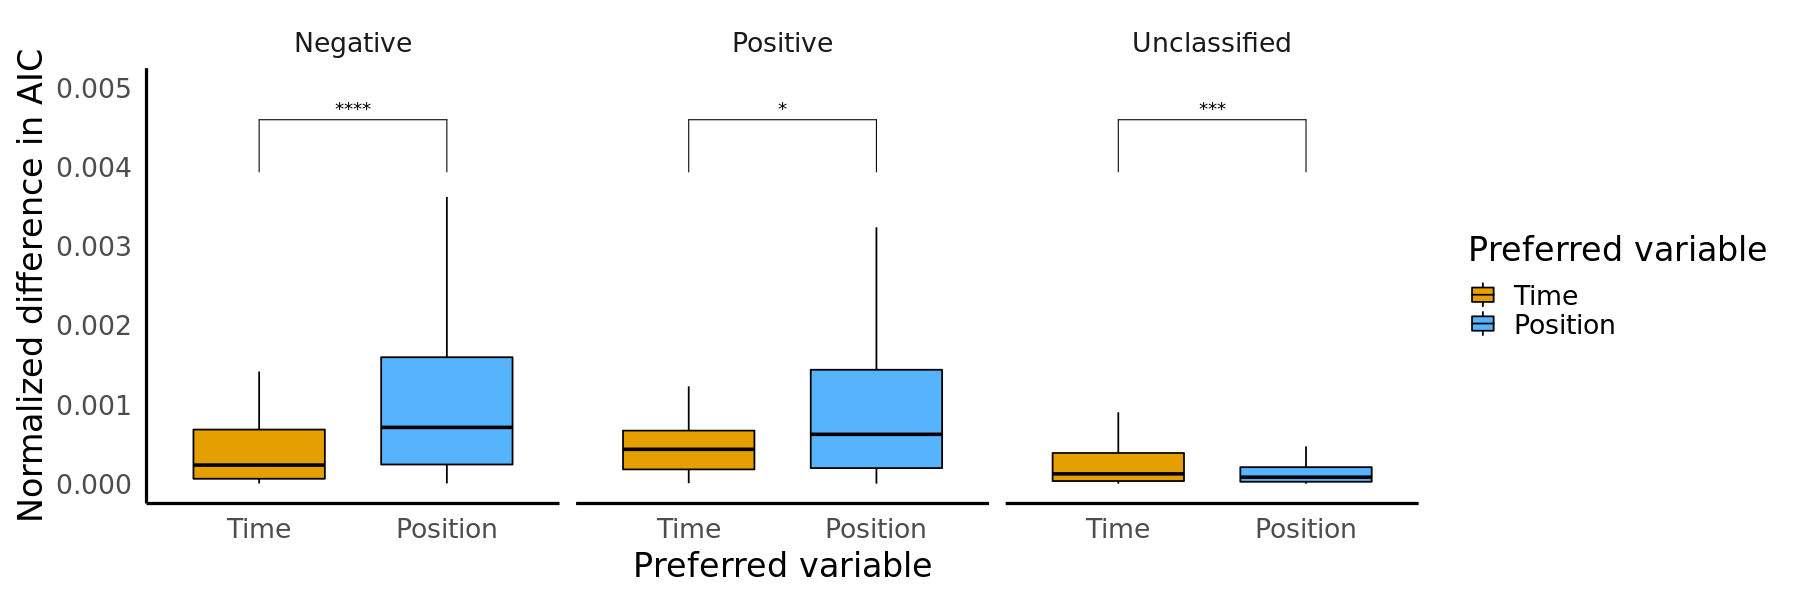

In [7]:
options(repr.plot.width=15, repr.plot.height=5)

# outbound 
comparison <- list(c("Time","Position"))
p2 <- data2plot %>%
  filter(models.trial_length_type=="All") %>%
  ggboxplot(x="aic_compare",y="aic_diff", fill="aic_compare",
            facet.by='lm_group_b', outlier.shape=NA) +
    scale_y_continuous(limits = c(0,0.005)) +
    scale_fill_manual(values=c("#E69F00","#56B4FF")) +
  stat_compare_means(comparison=comparison, method='wilcox.test',label = "p.signif",label.y=0.0035) +
 labs(fill='Preferred variable', x = 'Preferred variable', y="Normalized difference in AIC") +
 theme_minimal(base_size=20)+
theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),axis.line = element_line())


p2
ggsave('paper_figures/timeAnalysis_E.pdf',width=15,height=5)

In [36]:
data2plot %>%
  filter(models.trial_length_type=="All") %>%
    drop_na(aic_diff) %>%
    group_by(lm_group_b, aic_compare) %>%
    summarize(mean = mean(aic_diff))

`summarise()` has grouped output by 'lm_group_b'. You can override using the `.groups` argument.


lm_group_b,aic_compare,mean
<chr>,<fct>,<dbl>
Negative,Time,0.0004561630
Negative,Position,0.0017455416
Positive,Time,0.0005848858
Positive,Position,0.0014070952
Unclassified,Time,0.0003551751
Unclassified,Position,0.0002196749


In [8]:
data2plot %>%
  filter(models.trial_length_type=="All") %>%
    filter(lm_group_b == "Unclassified") -> data2compare
compare_means(aic_diff ~ aic_compare, method='wilcox.test',data=data2compare, details=TRUE) 


Adding missing grouping variables: `session_id`, `animal`, `cluster_id`


.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
aic_diff,Time,Position,0.0005356853,0.00054,0.00054,***,Wilcoxon
